In [2]:
from IPython.core.interactiveshell import InteractiveShell
# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm

In [4]:
matplotlib.rcParams.update({'font.size': 15})
sns.set_style('whitegrid')

In [5]:
%matplotlib notebook

## Load Data

In [6]:
t = pd.read_csv('billing_ticket_counts_2019-20.csv',
                names=('date', 'n_tix'), skiprows=1)
p = pd.read_csv('new_policy_counts_2019-20.csv',
                names=('date', 'n_pol'), skiprows=1)
inv = pd.read_csv('invoice_counts_2019-20.csv',
                  names=('date', 'n_inv'), skiprows=1)
df = t.merge(p, on='date').merge(inv, on='date')
df['tix_pol'] = df.n_tix/df.n_pol
df['tix_inv'] = df.n_tix/df.n_inv

In [7]:
df = df.replace({np.inf:None}).dropna()

In [8]:
df.head()

date  n_tix  n_pol  n_inv   tix_pol   tix_inv
0  2019-01-02     91     78    101  1.166667  0.900990
1  2019-01-03     61     47     83  1.297872  0.734940
2  2019-01-04     53     61     65  0.868852  0.815385
3  2019-01-05      2      4     88  0.500000  0.022727
4  2019-01-07     75     73    107  1.027397  0.700935

In [9]:
# !head print_receipt.csv

In [10]:
def read_amplitude_csv(fname, skiprows=6, agg_col_name='total'):
    '''Load csv file exported from Amplitude. Assumes format is 
    count of events per date, possibly multiple event types 
    whose counts will be aggregated.
    '''
    df = pd.read_csv(fname, skiprows=skiprows)
    df.columns = df.columns.str.strip()
    df = df.transpose()
    # agg across event columns, prob not generalizable
    df[agg_col_name] = df.sum(axis=1)
    df.drop(columns=df.columns[:-1], inplace=True)
    # assumes 'Event' col is a date
    df = df.iloc[1:, ].reset_index().rename(columns={'index': 'date'})
    return df

In [11]:
soi = read_amplitude_csv('soi.csv', agg_col_name='n_sched')
soi.head()

date n_sched
0  2020-01-07       0
1  2020-01-08       0
2  2020-01-09       0
3  2020-01-10       0
4  2020-01-11       0

In [12]:
pr = read_amplitude_csv('payment_receipt.csv', agg_col_name='n_payment_receipt')
pr.head()

date n_payment_receipt
0  2020-01-07                 0
1  2020-01-08                 0
2  2020-01-09                 0
3  2020-01-10                 0
4  2020-01-11                 0

In [13]:
prr = read_amplitude_csv('print_receipt.csv', skiprows=4, agg_col_name='n_print_receipt')
prr.head()

date n_print_receipt
0  2020-01-07               0
1  2020-01-08               0
2  2020-01-09               0
3  2020-01-10               0
4  2020-01-11               0

In [14]:
amp = soi.merge(pr, on='date').merge(prr, on='date')

In [15]:
amp.head()

date n_sched n_payment_receipt n_print_receipt
0  2020-01-07       0                 0               0
1  2020-01-08       0                 0               0
2  2020-01-09       0                 0               0
3  2020-01-10       0                 0               0
4  2020-01-11       0                 0               0

In [16]:
df = df.merge(amp, how='left', on='date').fillna(0)

In [17]:
for c in df.columns[-3:].tolist():
    name = '_'.join([c,'pol'])
    ma_name = '_'.join([name,'ma7'])
    df[name] = df[c]/df['n_pol']
    df[ma_name] = df[name].rolling(7).mean()

In [18]:
df.tail()

date  n_tix  n_pol  n_inv   tix_pol   tix_inv  n_sched  \
688  2020-12-30     66    232    671  0.284483  0.098361      206   
689  2020-12-31     43    239    547  0.179916  0.078611      105   
690  2021-01-01      2     31   1198  0.064516  0.001669       17   
691  2021-01-02      5     39    573  0.128205  0.008726       27   
692  2021-01-03      2     48    612  0.041667  0.003268       30   

     n_payment_receipt  n_print_receipt  n_sched_pol  n_sched_pol_ma7  \
688                 51              118     0.887931         0.951477   
689                 28               75     0.439331         0.923602   
690                  7                6     0.548387         0.840218   
691                  7               16     0.692308         0.832677   
692                 10               18     0.625000         0.867200   

     n_payment_receipt_pol  n_payment_receipt_pol_ma7  n_print_receipt_pol  \
688               0.219828                   0.245395             0.508621   
689               0.117155                   0.245925             0.313808   
690               0.225806                   0.245838             0.193548   
691               0.179487                   0.251871             0.410256   
692               0.208333                   0.226871             0.375000   

     n_print_receipt_pol_ma7  
688                 0.662903  
689                 0.632702  
690                 0.566012  
691                 0.567198  
692                 0.561245

## Plots & Stats

### Tickets per policy

Numer of tickets per new policy, with 7-day moving average.  
More than 50% change in mean # tix/policy before and after time period of 3/1/20 - 9/1/20.

<IPython.core.display.Javascript object>


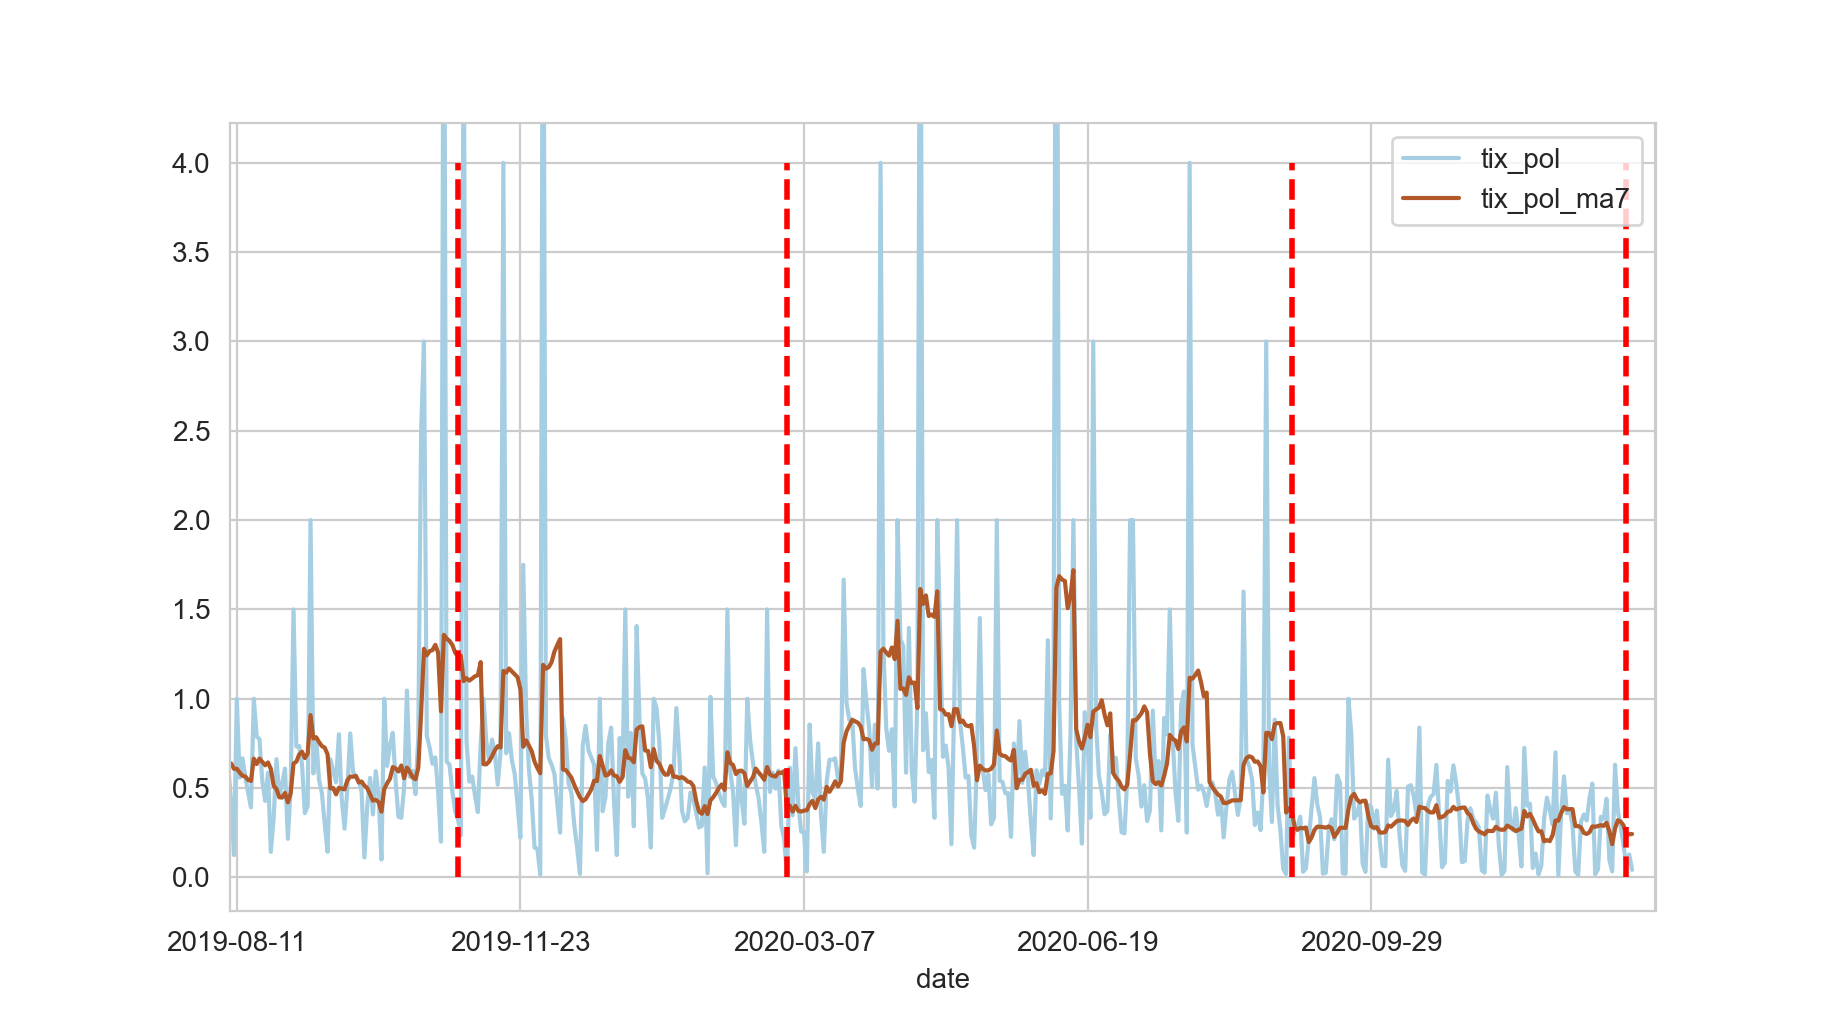

In [19]:
cmap = cm.get_cmap('Paired')  # Paired, Dark2, Accent, Set1, tab10, Pastel1
sns.set_style('whitegrid')
df['tix_pol_ma7'] = df['tix_pol'].rolling(7).mean()
ax = df.plot(x='date', y=['tix_pol', 'tix_pol_ma7',
#                      'n_sched_pol_ma7', 'n_payment_receipt_pol_ma7',
#                      'n_print_receipt_pol_ma7'
                    ], cmap=cmap
        )
ax.vlines([df[df.date=='2019-11-01'].index, 
           df[df.date=='2020-03-01'].index,
           df[df.date=='2020-09-01'].index,
           df[df.date=='2021-01-01'].index
          ],0,4,linestyles='--',colors='r',linewidth=2, zorder=3)

### Comparison with New Billing Feature Amplitude Events

Added 7-day moving average of num amplitude events per new policy for comparison.

<IPython.core.display.Javascript object>


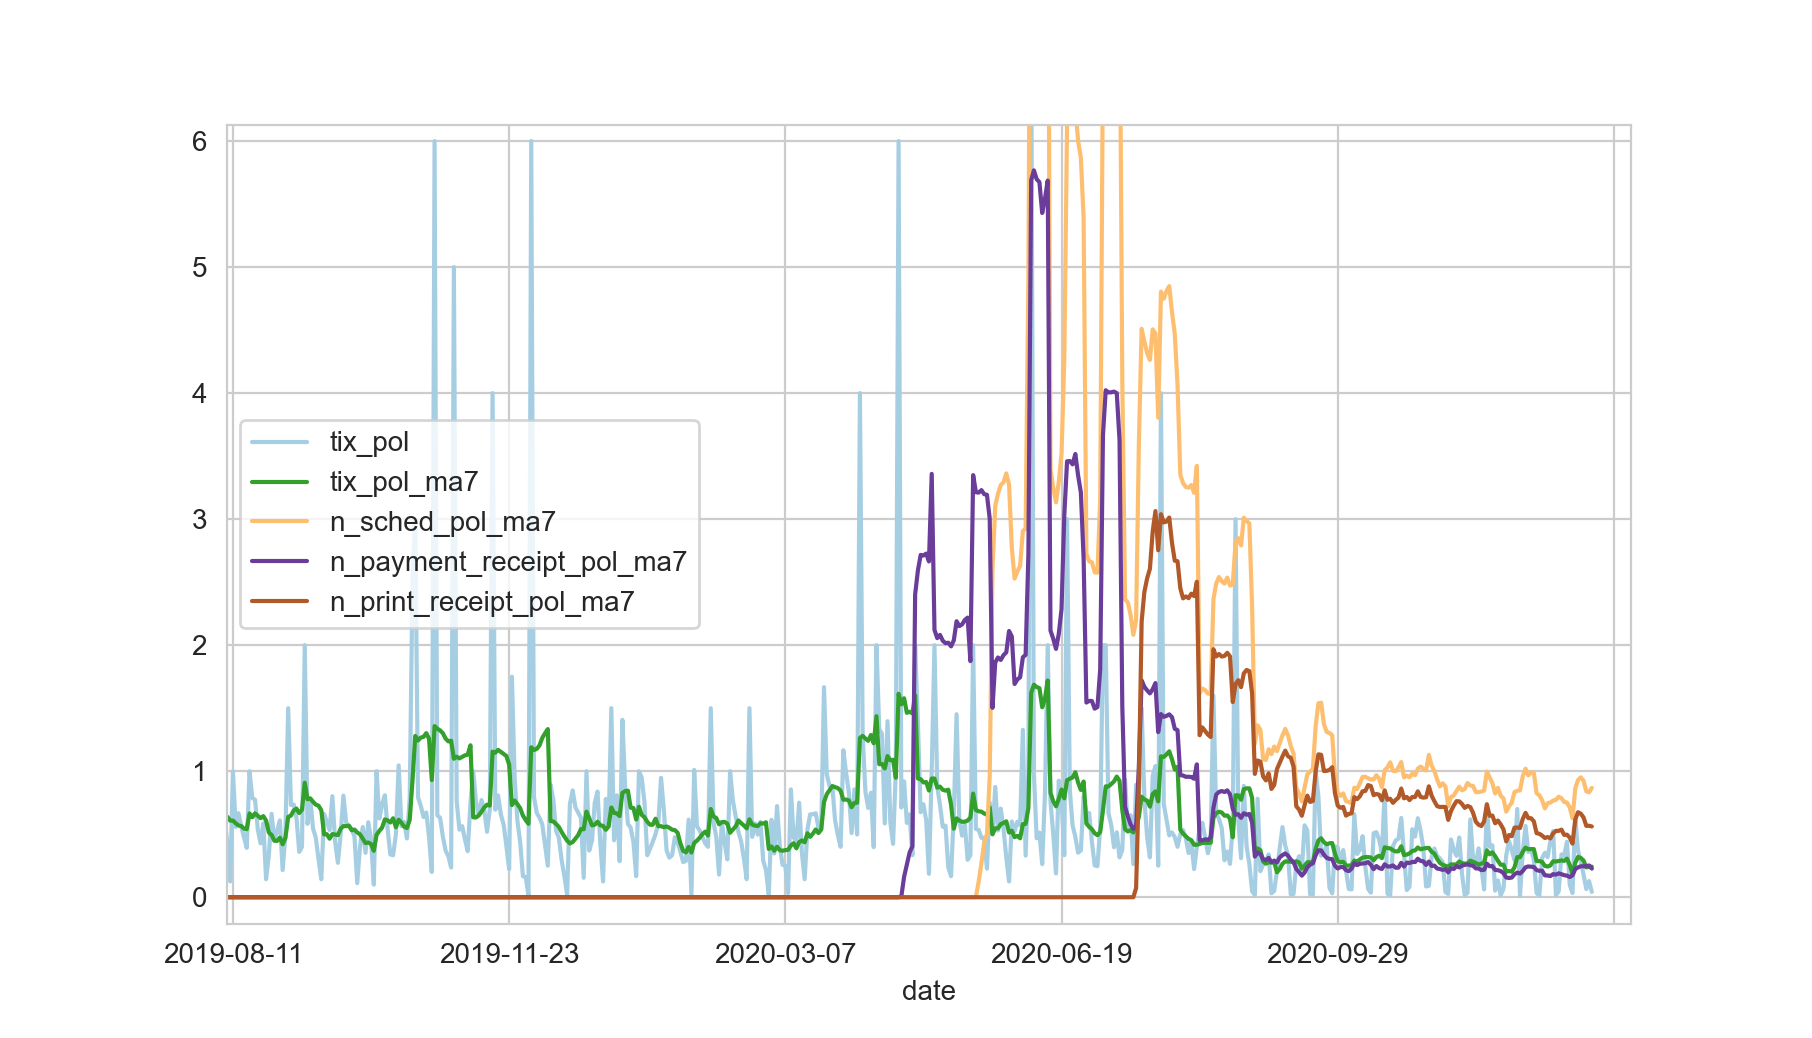

In [227]:
cmap = cm.get_cmap('Paired')  # Paired, Dark2, Accent, Set1, tab10, Pastel1
sns.set_style('whitegrid')
df['tix_pol_ma7'] = df['tix_pol'].rolling(7).mean()
df.plot(x='date', y=['tix_pol', 'tix_pol_ma7',
                     'n_sched_pol_ma7', 'n_payment_receipt_pol_ma7',
                     'n_print_receipt_pol_ma7'
                    ], cmap=cmap
        )

### Tickets per Invoice

Numer of tickets per invoice, with 7-day moving average.  
Downward trend over all time.

<IPython.core.display.Javascript object>


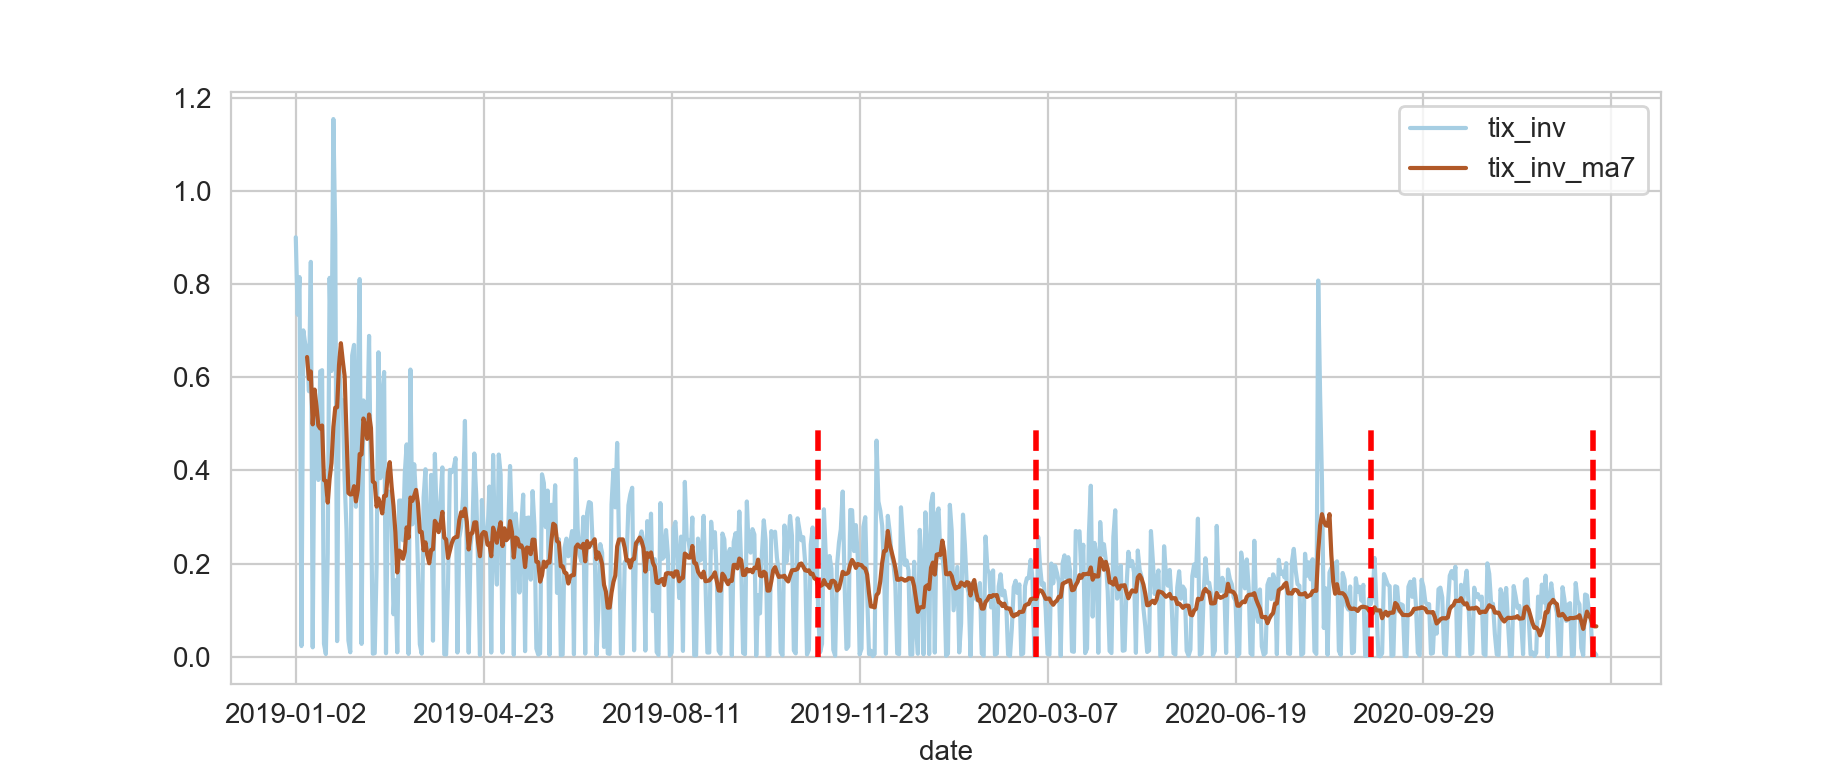

In [234]:
cmap = cm.get_cmap('Paired')
df['tix_inv_ma7'] = df['tix_inv'].rolling(7).mean()
ax = df.plot(x='date', y=['tix_inv', 'tix_inv_ma7',
#                      'n_sched_pol_ma7', 'n_payment_receipt_pol_ma7',
#                      'n_print_receipt_pol_ma7'
                    ],cmap=cmap)

ax.vlines([df[df.date=='2019-11-01'].index, 
           df[df.date=='2020-03-01'].index,
           df[df.date=='2020-09-01'].index,
           df[df.date=='2021-01-01'].index
          ],0,0.5,linestyles='--',colors='r',linewidth=2, zorder=3)

### Statistics

Some statistics for 3 time periods: 

In [236]:
for s, e in [('2019-11-01', '2020-03-01'),
             ('2020-03-01', '2020-09-01'),
             ('2020-09-01', '2021-01-01')]:
    print(f"{s} to {e}, Mean ± stddev ------")
    for c in df.columns[1:6].tolist():
        print(
            f"{c}: {df[df.date.between(s,e)][c].mean():.2f}"
            f" ± {df[df.date.between(s,e)][c].std():.2f}")
    print('\n')

2019-11-01 to 2020-03-01, Mean ± stddev ------
n_tix: 66.81 ± 49.20
n_pol: 123.68 ± 82.22
n_inv: 489.15 ± 164.69
tix_pol: 0.68 ± 0.78
tix_inv: 0.15 ± 0.11


2020-03-01 to 2020-09-01, Mean ± stddev ------
n_tix: 69.58 ± 44.20
n_pol: 136.64 ± 103.34
n_inv: 542.13 ± 178.61
tix_pol: 0.79 ± 0.85
tix_inv: 0.14 ± 0.11


2020-09-01 to 2021-01-01, Mean ± stddev ------
n_tix: 55.40 ± 37.19
n_pol: 161.55 ± 84.90
n_inv: 642.62 ± 180.33
tix_pol: 0.30 ± 0.21
tix_inv: 0.09 ± 0.06


